# Hidden Markov Tree

In [1]:
%load_ext rpy2.ipython
%matplotlib inline
import sys
import h5py
import warnings
import pickle
import numpy as np
import pandas as pd
import stream as st
import matplotlib.pyplot as plt
from anndata import AnnData
from sklearn.metrics import confusion_matrix

import utility_functions as uf
import matrices as mat
import hmt_expectation_maximization as hmtem

warnings.filterwarnings("ignore", category=RuntimeWarning)

### Load dataset

In [2]:
data_file = 'datafile.hdf5'
dev_abb = ['PMY', 'MY', 'MMY', 'BNE', 'SNE', 'BL', 'BA', 'EO', 'LY', 'PC']
dev_map = {name: i for i, name in enumerate(dev_abb)}

f = h5py.File(data_file, 'r')
X = np.array(f['train']['X'])
Y = np.array(f['train']['y']).flatten()
ID = f.attrs['filenames']
f.close()

classes = np.array([dev_abb[y] for y in Y])
print(X.shape, Y.shape)

(1821, 50) (1821,)


The dataset consists of 1821 feature vectors of the ten classes promyelocyte (PMY), myelocyte (MY), metamyelocyte (MMY), band neutrophil (BNE), segmented neutrophil (SNE), blast (BL), basophil (BA), eosinophil (EO), lymphocyte (LY), and plasma cells (PC).

### Calculate pseudotime using STREAM

https://github.com/pinellolab/STREAM

In [3]:
X_adata = AnnData(X)
X_adata.uns['label_color'] = {'PMY': '#4d76ff', 'BL': '#f14cc1', 'MY': '#ff7c00','BA': '#a3a3a3', 'MMY': '#1ac938', 
                              'EO': '#ffc400', 'BNE': '#e8000b', 'LY': '#33e0ff', 'SNE': '#a862ea', 'PC': '#FFDEAD'}

col = ['#4d76ff', '#ff7c00', '#1ac938', '#e8000b', '#a862ea', '#f14cc1', 
       '#a3a3a3','#ffc400', '#33e0ff', '#FFDEAD']
colors = np.repeat('#color#', 1821)
for i in range(len(dev_abb)):
    colors[Y == i] = col[i]

X_adata.obs['label_color'] = colors
X_adata.obs['label'] = classes
X_adata.uns['experiment'] = 'rna-seq'

50 variable genes are selected


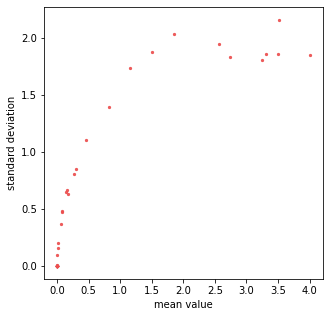

In [4]:
st.log_transform(X_adata)
st.select_variable_genes(X_adata, loess_frac=0.1)

8 cpus are being used ...
Importing precomputed umap visualization ...


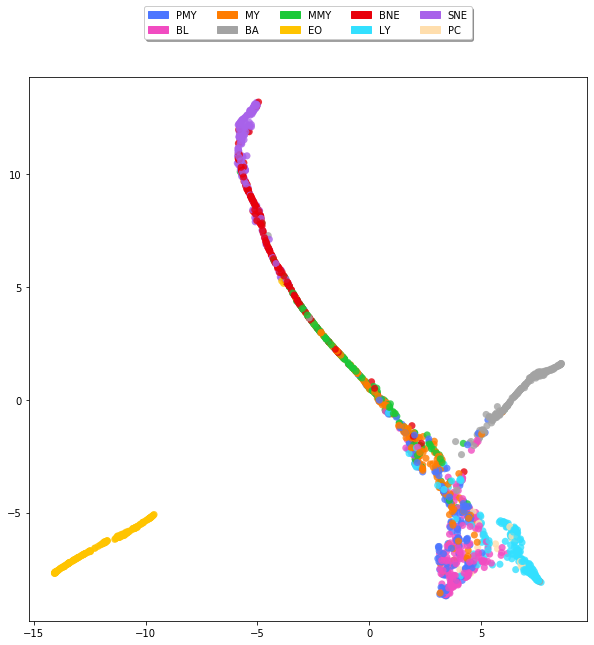

In [6]:
st.dimension_reduction(X_adata, n_components=3)
st.plot_visualization_2D(X_adata, fig_legend_ncol=5)

In [7]:
st.seed_elastic_principal_graph(X_adata, clustering='ap')
st.elastic_principal_graph(X_adata, epg_alpha=0.007)

Seeding initial elastic principal graph...
Clustering...
Affinity propagation ...
The number of initial nodes is 24
Calculatng minimum spanning tree...
Number of initial branches: 8
epg_n_nodes is too small. It is corrected to the initial number of nodes plus incr_n_nodes
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 54 nodes on 1821 points and 3 dimensions"


[1]
 "Using a single core"


Nodes = 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 
50
 
51
 
52
 
53
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

3||54
	
5.47e-05
	
54
	
53
	
46
	
3
	
0
	
0
	
2.309e-05
	
2.144e-05
	
0.986
	
0.987
	
2.881e-05
	
2.794e-06
	
0.0001509
	
0.008148
	
0


15.03 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 7


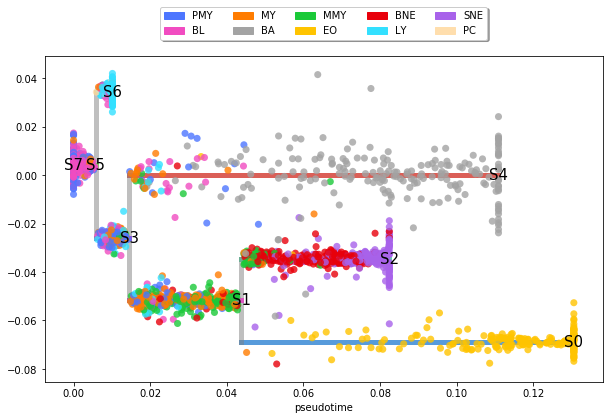

In [8]:
st.subwaymap_plot(X_adata, percentile_dist=99,root='S7',fig_legend_ncol=5,preference=['S6', 'S4']) 

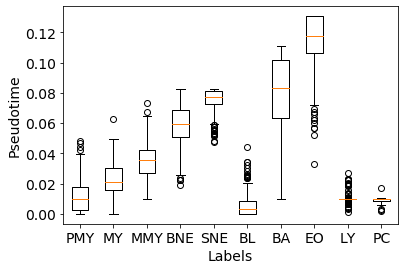

In [9]:
uf.hmt_boxplot_ptime(X_adata, dev_abb)

In [10]:
# Information about the tree has been stored in the variables X_obs and tree_obs.
# tree_obs is a dictionary containing information about the parents, children, root node, and leaf nodes.
X_obs = pd.read_pickle('X_obs')
pkl_file = open('tree_obs', 'rb')
tree_obs = pickle.load(pkl_file)
pkl_file.close()

In [11]:
X_obs.head()

,label,label_color,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S7_pseudotime,S2_pseudotime,S1_pseudotime,S6_pseudotime,S4_pseudotime,S5_pseudotime
0,LY,#00d7ff,46,"(46, 20)","(S6, S5)",0.000000,0.003002,0.129041,0.013008,0.010148,0.080882,0.042237,0.000000,0.109375,0.004315
1,MY,#ff7c00,7,"(13, 1)","(S1, S3)",0.016760,0.000076,0.103563,0.012469,0.026995,0.055405,0.016760,0.025477,0.108836,0.021162
2,EO,#ffc400,0,"(0, 13)","(S0, S1)",0.000161,0.002831,0.000161,0.115871,0.130397,0.125287,0.086642,0.128879,0.212238,0.124564
3,LY,#00d7ff,49,"(52, 1)","(S4, S3)",0.088740,0.003122,0.123659,0.007627,0.022153,0.075501,0.036855,0.020635,0.088740,0.016320
4,SNE,#8b2be2,10,"(4, 13)","(S2, S1)",0.008091,0.001382,0.117358,0.059783,0.074309,0.008091,0.030554,0.072791,0.156149,0.068476


In [12]:
# Pseudotime difference between a node and the parent of the node
pt_diff = []
for i in range(len(X_obs.index)):
        parent = tree_obs['parents'][str(i)]
        if parent != None:
            pt_diff.append(X_obs.loc[str(i)]['S7_pseudotime'] - X_obs.loc[parent]['S7_pseudotime'])
pt_diff = np.array(pt_diff)

### EM algorithm

In [13]:
# Rescale the pseudotime differences.
pt_diff_max = 1
pt_diff_rescaled = pt_diff_max * (pt_diff - np.max(pt_diff)) / (np.max(pt_diff) - 
                                                                np.min(pt_diff)) + pt_diff_max
# Rescaled lmbda_fix
lmbda_fix_re = []
for abb in dev_abb:
    ptime_class = np.sort(X_obs.loc[X_obs['label'] == abb]['S7_pseudotime'])
    diff = ptime_class[1:] - ptime_class[:-1]
    diff_rescaled = pt_diff_max * (diff - np.max(diff)) / (np.max(diff) - np.min(diff)) + pt_diff_max
    lmbda_fix_re.append(np.log(2)/np.median(diff_rescaled))

ptime_class = np.sort(X_obs.loc[X_obs['label'] == 'LY']['S7_pseudotime'])
diff = ptime_class[1:] - ptime_class[:-1]
diff_rescaled = pt_diff_max * (diff - np.max(diff)) / (np.max(diff) - np.min(diff)) + pt_diff_max
lmbda_fix_re[8] = 1/np.mean(diff_rescaled)
lmbda_fix_re = np.array(lmbda_fix_re)

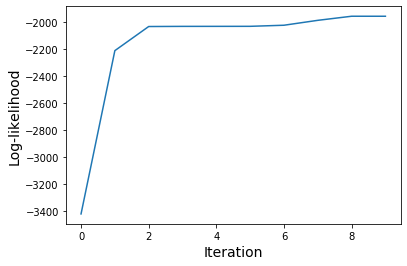

In [14]:
p, lmbda, p_hist, lmbda_hist, loglik_hist = hmtem.hmt_EM_algorithm(lmbda_fix_re, 100, X_obs, tree_obs, 
                                                                   pt_diff_rescaled, dev_map)

plt.figure()
plt.plot(range(len(loglik_hist)) , loglik_hist)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log-likelihood', fontsize=14)
plt.show()

### Results

In [15]:
tm = mat.hmt_transition_matrix(p, lmbda, lmbda_fix_re, X_obs, tree_obs)
M, X_obs = uf.hmt_viterbi(X_obs, tree_obs, tm, dev_abb, dev_map)
acc =  len(np.where(X_obs['label'] == X_obs['Z'])[0])/1821
print('Accuracy: ', acc)
branches = ['branch S7-S5', 'branch S6-S5', 'branch S5-S3', 'branch S4-S3', 
            'branch S1-S3', 'branch S2-S1', 'branch S0-S1']
transition_idx = dict()
for b in branches:
    branch = list(reversed(tree_obs[b]))
    parent = tree_obs['parents'][branch[0]]
    if parent != None:
        if X_obs.loc[parent].Z != X_obs.loc[branch[0]].Z:
            transition_idx[X_obs.loc[parent].Z + '-' + X_obs.loc[branch[0]].Z] = branch[0]
    Z = X_obs.loc[branch].Z
    for i in range(len(Z)-1):
        if Z[i] != Z[i+1]:
            transition_idx[Z[i] + '-' + Z[i+1]] = branch[i+1]
print('Transition indices: ', transition_idx)

Accuracy:  0.6869851729818781
Transition indices:  {'BL-LY': '1300', 'BL-PMY': '1589', 'PMY-BA': '1034', 'PMY-MY': '682', 'MY-MMY': '289', 'MMY-BNE': '818', 'BNE-SNE': '223', 'MMY-EO': '1128'}


In [16]:
X_obs.head()

,label,Z,branch_id_alias,S7_pseudotime,branch_id,node,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S2_pseudotime,S1_pseudotime,S6_pseudotime,S4_pseudotime,S5_pseudotime,label_color
0,LY,LY,"(S6, S5)",0.010148,"(46, 20)",46,0.000000,0.003002,0.129041,0.013008,0.080882,0.042237,0.000000,0.109375,0.004315,#00d7ff
1,MY,MY,"(S1, S3)",0.026995,"(13, 1)",7,0.016760,0.000076,0.103563,0.012469,0.055405,0.016760,0.025477,0.108836,0.021162,#ff7c00
2,EO,EO,"(S0, S1)",0.130397,"(0, 13)",0,0.000161,0.002831,0.000161,0.115871,0.125287,0.086642,0.128879,0.212238,0.124564,#ffc400
3,LY,PMY,"(S4, S3)",0.022153,"(52, 1)",49,0.088740,0.003122,0.123659,0.007627,0.075501,0.036855,0.020635,0.088740,0.016320,#00d7ff
4,SNE,SNE,"(S2, S1)",0.074309,"(4, 13)",10,0.008091,0.001382,0.117358,0.059783,0.008091,0.030554,0.072791,0.156149,0.068476,#8b2be2


In [17]:
transition_times = dict()
for key in transition_idx.keys():
    time_parent = X_obs.loc[tree_obs['parents'][transition_idx[key]]].S7_pseudotime
    time_child = X_obs.loc[transition_idx[key]].S7_pseudotime
    ttime = (time_child + time_parent) / 2
    transition_times[key] = ttime   
print('Transition times: ', transition_times)

Transition times:  {'BL-LY': 0.008965597123806915, 'BL-PMY': 0.008602868855680734, 'PMY-BA': 0.030941679153713805, 'PMY-MY': 0.016879857589636022, 'MY-MMY': 0.03055554361698808, 'MMY-BNE': 0.0481171458302563, 'BNE-SNE': 0.07371209379134344, 'MMY-EO': 0.04626072495113468}


Normalized confusion matrix


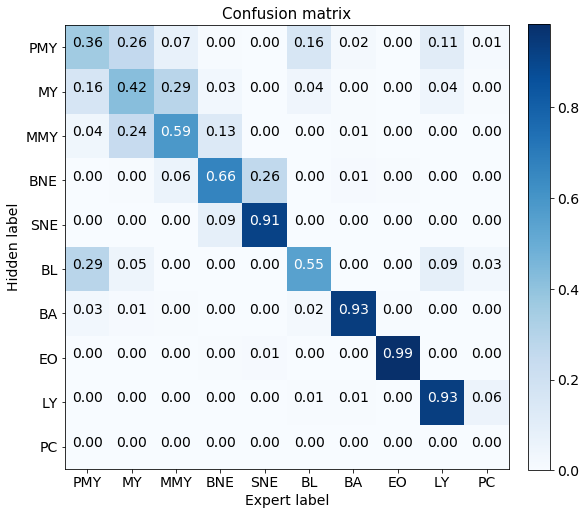

In [18]:
labels = np.array(X_obs.label)
for abb in dev_abb:
    labels[np.where(labels == abb)] = dev_map[abb]
labels = labels.astype(int)

Z = np.array(X_obs.Z)
for abb in dev_abb:
    Z[np.where(Z == abb)] = dev_map[abb]
Z = Z.astype(int)

plt.figure(figsize=(8,8))
uf.plot_confusion_matrix(confusion_matrix(Z, labels), classes=dev_abb, normalize=True)
plt.title('Confusion matrix', fontsize=15)
plt.show()

In [19]:
X_adata.obs['label'] = np.array(X_obs.Z)
colors = np.repeat('#color#', 1821)
for i in range(len(dev_abb)):
    colors[Z == i] = col[i]
X_adata.obs['label_color'] = colors

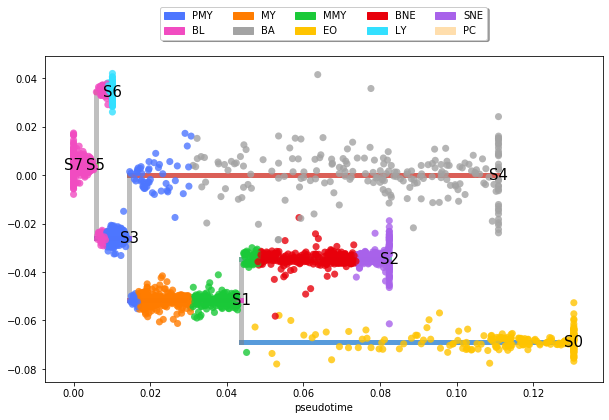

In [20]:
# Classification according to the hidden Markov tree
st.subwaymap_plot(X_adata, percentile_dist=99,root='S7',fig_legend_ncol=5,preference=['S6', 'S4']) 